### Setup and Imports

In [2]:
!pip install -U -q matplotlib

In [1]:
import re
import numpy as np
from matplotlib import pyplot as plt

from transformers import (
    AutoProcessor,
    PaliGemmaForConditionalGeneration
)
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configs

In [3]:
dataset_id = "catworld1212/pali-gemma-dataset"
model_id = "google/paligemma-3b-pt-224"

device = "cuda:0"
dtype = torch.bfloat16

batch_size = 1 #batch size 1 as there are only 2 images
learning_rate = 5e-5

### Dataset for Fine Tuning


In [5]:
#no test train validation split 
dataset = load_dataset(dataset_id, split="train")
train_dataset = dataset

In [7]:
train_dataset

Dataset({
    features: ['image', 'instruction_prompt', 'output'],
    num_rows: 2
})

In [8]:
print(f"{len(train_dataset)=}")


len(train_dataset)=2


In [9]:
import os
import getpass
os.environ["HF_TOKEN"] = getpass.getpass("HF TOKEN:")

HF TOKEN: ········


In [10]:
processor = AutoProcessor.from_pretrained(model_id)

In [12]:
# 3. Data Collation Function
image_token = processor.tokenizer.convert_tokens_to_ids("<image>")

#John's version
# def collate_fn(examples):
#     texts = [example["instruction_prompt"] for example in examples]
#     labels = [example["output"] for example in examples]
#     images = [example["image"].convert("RGB") for example in examples]
#     tokens = processor(text=texts, images=images,
#                        return_tensors="pt", padding="longest")
#     tokens["labels"] = processor.tokenizer(
#         labels, padding="longest", return_tensors="pt").input_ids
#     tokens = tokens.to(torch.bfloat16).to(device)
#     return tokens


def collate_fn(examples):
    prompts = [example["instruction_prompt"] for example in examples]
    suffix = [example["output"] for example in examples] #will be used as labels
    images = [example["image"].convert("RGB") for example in examples]
    inputs = processor(images=images,
                       text=prompts,
                       suffix = suffix,
                       return_tensors="pt", 
                       padding="longest")
    
    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs


In [13]:

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=batch_size,
    shuffle=True,
)


### Model Creation

In [14]:

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


### Freezing everything but the Attention Layers

In [15]:

for name, param in model.named_parameters():
    if "attn" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [16]:

for name, param in model.named_parameters():
    print(f"{name:<70}: requires_grad={param.requires_grad}, dtype={param.dtype}")

vision_tower.vision_model.embeddings.patch_embedding.weight           : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.patch_embedding.bias             : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.position_embedding.weight        : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.bias      : requires_grad=True, d

### Dummy Forward Passs

In [17]:
train_batch = next(iter(train_dataloader))

In [18]:
print(f"{train_batch.keys()=}")


train_batch.keys()=dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'labels'])


In [19]:
#token_type_ids is now present, it wasn't present in the earlier code 

In [20]:
outputs = model(**train_batch)
print(f"{outputs.loss=}")

outputs.loss=tensor(5.0840, device='cuda:0', grad_fn=<NllLossBackward0>)


In [21]:
#Getting a loss value - earlier was getting None

In [39]:
#outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5703125..1.0].


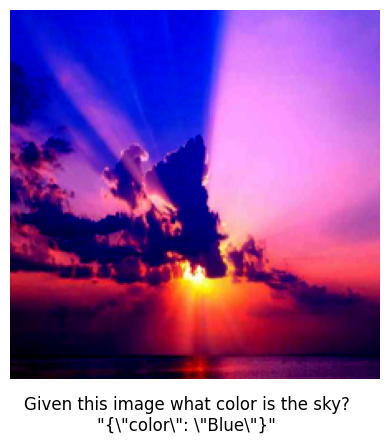

In [22]:
index = 0

plt.imshow(train_batch["pixel_values"][index].permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

generated_outputs = model.generate(
    **train_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[index]

plt.figtext(
    0.5, 0.01,
    generated_outputs,
    wrap=True,
    horizontalalignment="center",
    fontsize=12
)

plt.show()

### Fine tune the Model

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        if idx % 10 == 0:
            print(f"Epoch: {epoch} Iter: {idx} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0 Iter: 0 Loss: 5.0840
Epoch: 1 Iter: 0 Loss: 2.1843
Epoch: 2 Iter: 0 Loss: 0.3485
Epoch: 3 Iter: 0 Loss: 0.0905
Epoch: 4 Iter: 0 Loss: 0.0102
Epoch: 5 Iter: 0 Loss: 0.0046
Epoch: 6 Iter: 0 Loss: 0.0023
Epoch: 7 Iter: 0 Loss: 0.0018
Epoch: 8 Iter: 0 Loss: 0.0010
Epoch: 9 Iter: 0 Loss: 0.0008


### Results after Fine Tuning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5703125..1.0].


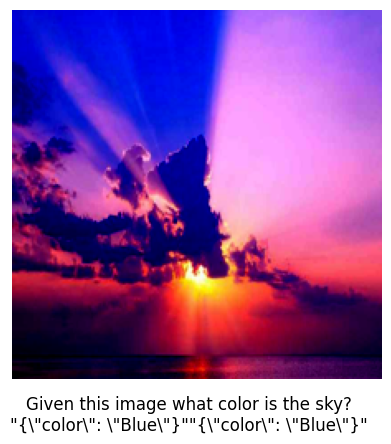

In [25]:
#testing ans training on same data - bad approach - limited by dataset - 2 rows
index = 0

plt.imshow(train_batch["pixel_values"][index].permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

generated_outputs = model.generate(
    **train_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[index]

plt.figtext(
    0.5, 0.01,
    generated_outputs,
    wrap=True,
    horizontalalignment="center",
    fontsize=12
)

plt.show()